# Model Experiments

In [39]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

In [40]:
conn = sqlite3.connect('../data/fires.sqlite')
cur = conn.cursor()

df_raw = pd.read_sql_query("""
select
	weather_geo.long,
	weather_geo.lat,
	weather_geo.month,
	weather_geo.date,
	weather_geo.precipitation,
	weather_geo.pressure,
	weather_geo.humidity_2m,
	weather_geo.temp_2m,
	weather_geo.temp_dew_point_2m,
	weather_geo.temp_wet_bulb_2m,
	weather_geo.temp_max_2m,
	weather_geo.temp_min_2m,
	weather_geo.temp_range_2m,
	weather_geo.temp_0m,
	weather_geo.wind_10m,
	weather_geo.wind_max_10m,
	weather_geo.wind_min_10m,
	weather_geo.wind_range_10m,
	weather_geo.wind_50m,
	weather_geo.wind_max_50m,
	weather_geo.wind_min_50m,
	weather_geo.wind_range_50m,
	weather_geo.drought_score,
	soil.elevation,
	soil.slope_005,
	soil.slope_005_02,
	soil.slope_02_05,
	soil.slope_05_10,
	soil.slope_10_15,
	soil.slope_15_30,
	soil.slope_30_45,
	soil.slope_45,
	soil.aspect_north,
	soil.aspect_east,
	soil.aspect_south,
	soil.aspect_west,
	soil.aspect_unknown,
	soil.water_land,
	soil.barren_land,
	soil.urban_land,
	soil.grass_land,
	soil.forest_land,
	soil.partial_cultivated_land,
	soil.irrigated_land,
	soil.cultivated_land,
	soil.nutrient,
	soil.nutrient_retention,
	soil.rooting,
	soil.oxygen,
	soil.excess_salts,
	soil.toxicity,
	soil.workablity,
	ifnull(fires_rollup.prior_fire_0_1_year, 0) as prior_fire_0_1_year,
	ifnull(fires_rollup.prior_fire_1_2_year, 0) as prior_fire_1_2_year,
	ifnull(fires_rollup.prior_fire_2_3_year, 0) as prior_fire_2_3_year,
	ifnull(fires_rollup.prior_fire_3_4_year, 0) as prior_fire_3_4_year,
	ifnull(fires_rollup.prior_fire_4_5_year, 0) as prior_fire_4_5_year,

  ifnull(fires_rollup.fire_size_class, '') as fire_size_class
from weather_geo
inner join soil
  on soil.fips = weather_geo.fips
left outer join fires_rollup
  on fires_rollup.date = weather_geo.date
  and fires_rollup.long = weather_geo.long
  and fires_rollup.lat = weather_geo.lat
	and fires_rollup.cause in ('Other causes', 'Natural', 'Power', 'Recreation', 'Smoking', 'Missing/Undefined', 'Railroad', 'Equipment Use')
where
	weather_geo.date >= '2008-01-01'
	and weather_geo.date < '2010-01-01'
	and weather_geo.day in (1, 8, 15, 22, 28) -- remove once models are stable
""", conn)

conn.close()

df_raw['date'] = df_raw['date'].astype('datetime64[ns]')

df_raw.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
long,96192.0,-119.622380,2.509257,-124.25,-121.500000,-120.000000,-117.500000,-114.250000
lat,96192.0,37.251871,2.573248,32.75,35.000000,37.000000,39.500000,42.000000
month,96192.0,6.500000,3.452070,1.00,3.750000,6.500000,9.250000,12.000000
precipitation,96192.0,1.119288,4.154169,0.00,0.000000,0.000000,0.060000,60.910000
pressure,96192.0,91.856980,6.466091,72.70,87.800000,92.690000,97.050000,102.860000
humidity_2m,96192.0,4.971889,1.927972,1.04,3.540000,4.760000,6.230000,16.110000
temp_2m,96192.0,14.383837,9.298172,-16.37,7.740000,13.690000,21.340000,39.320000
temp_dew_point_2m,96192.0,1.376102,6.052551,-18.67,-2.770000,1.790000,5.850000,21.010000
temp_wet_bulb_2m,96192.0,7.879939,6.526468,-17.52,3.460000,7.990000,12.710000,26.690000
temp_max_2m,96192.0,21.879978,10.852743,-12.18,13.890000,21.570000,30.490000,47.700000


In [41]:
final = df_raw.isna().sum()
cols = []
for count, col in zip(final,list(df_raw.columns)):
    if count > 0:
        cols.append(col)

print(f'Columns with null: {cols}')

Columns with null: []


In [42]:
df_fire_false = df_raw[df_raw.fire_size_class == '']
df_fire_true = df_raw[df_raw.fire_size_class != '']
print(f'Unbalanced classes of NO fire: {len(df_fire_false):,} and YES fire: {len(df_fire_true):,}')

df_fire_true_balanced = df_fire_true.sample(n=len(df_fire_false), replace=True)

df_fires = pd.concat([df_fire_false, df_fire_true_balanced], axis=0)
df_fire_false = df_fires[df_fires.fire_size_class == '']
df_fire_true = df_fires[df_fires.fire_size_class != '']
print(f'Balanced classes of NO fires: {len(df_fire_false):,} and YES fire: {len(df_fire_true):,}')

df_fires['has_fire'] = df_fires.fire_size_class > ''

df_fires_numeric = df_fires.drop(['date', 'fire_size_class', 'has_fire'], axis=1)

df_fires_encoded = pd.get_dummies(df_fires_numeric, columns=['month'])

scaler = StandardScaler()
scaler.fit(df_fires_encoded)

X = scaler.transform(df_fires_encoded)
y = df_fires.has_fire

num_fires = (df_fires.has_fire == True).sum()
num_data_pt = len(y)
print(f'{num_fires} fires out of {len(y)} data points')
print(f'No fires {(1 - round(num_fires/num_data_pt, 2)) * 100}% of the time (ie Balanced)')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Unbalanced classes of NO fire: 88,017 and YES fire: 8,175
Balanced classes of NO fires: 88,017 and YES fire: 88,017
88017 fires out of 176034 data points
No fires 50.0% of the time (ie Balanced)


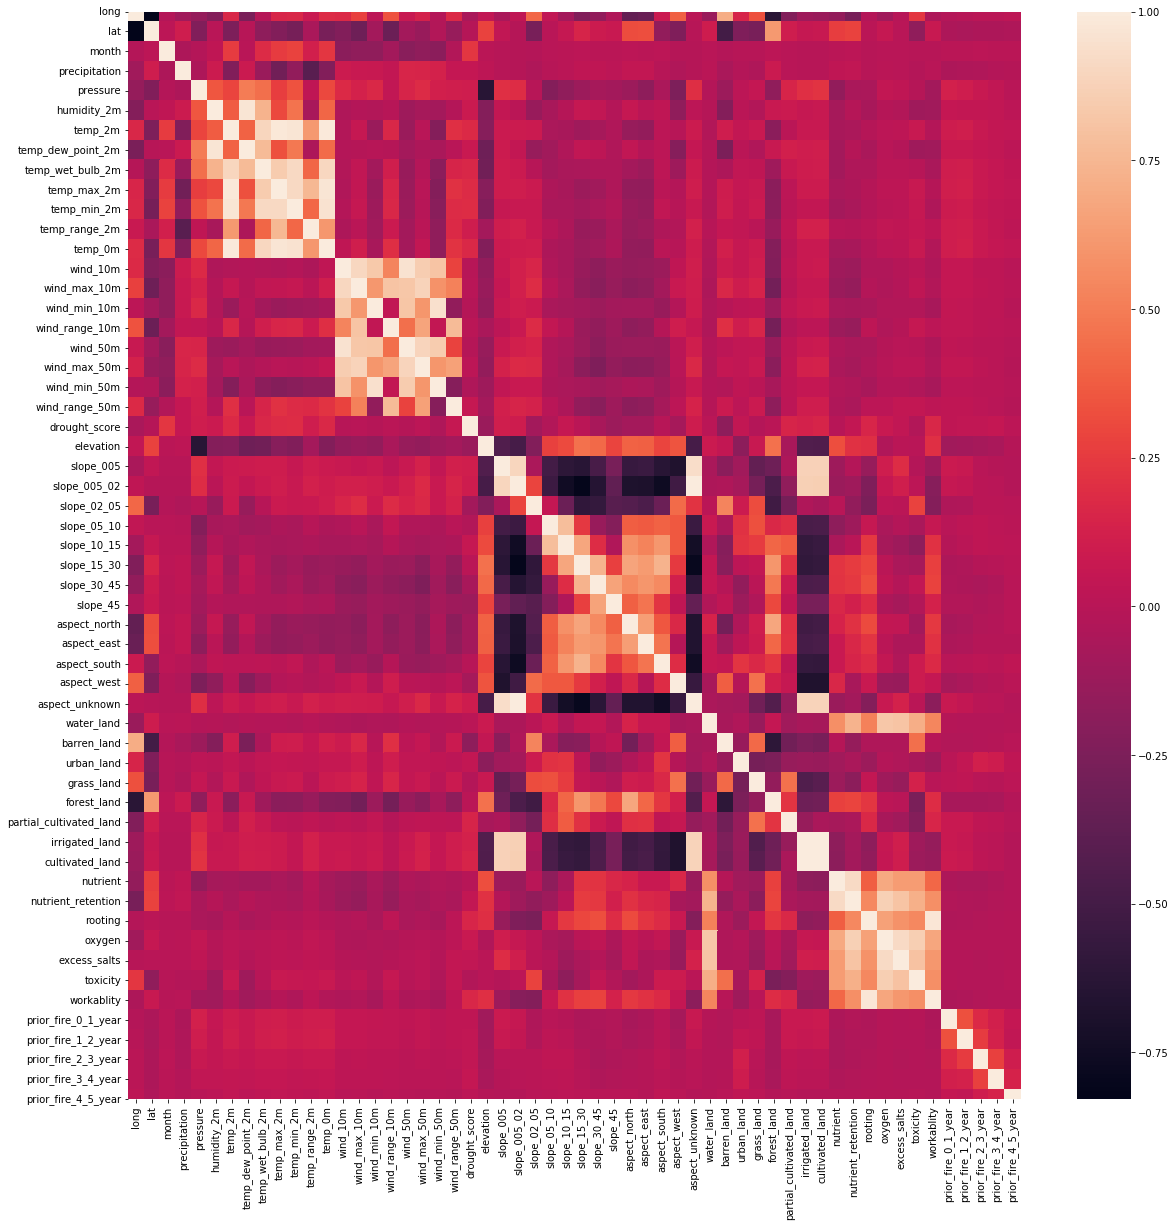

In [43]:
plt.figure(figsize=(20, 20))
sns.heatmap(df_fires_numeric.corr())

### All Fire Sizes (A-G)

In [44]:
params={
  'C': [0.1],
}

log_reg = LogisticRegression(solver='liblinear', max_iter=1000)
log_reg = GridSearchCV(estimator=log_reg, param_grid=params, scoring='recall', cv=5)

log_reg.fit(X_train, y_train)

print(f'All size fires estimator', log_reg.best_estimator_)

y_pred_log_reg = log_reg.predict(X_test)

print('--------- Log Regression Classification ---------')
print(classification_report(y_test, y_pred_log_reg))

All size fires estimator LogisticRegression(C=0.1, max_iter=1000, solver='liblinear')
--------- Log Regression Classification ---------
              precision    recall  f1-score   support

       False       0.77      0.75      0.76     66116
        True       0.75      0.77      0.76     65909

    accuracy                           0.76    132025
   macro avg       0.76      0.76      0.76    132025
weighted avg       0.76      0.76      0.76    132025



In [45]:
from sklearn.linear_model import SGDClassifier

# params = {
#   'loss': ['hinge', 'squared_hinge'],
#   'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
#   'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
#   'eta0': [0, 0.1, 1, 5]
# }
# For performance just use the best params from last run
params = {'loss': ['squared_hinge'], 'learning_rate': ['optimal'], 'eta0': [0.1], 'alpha': [0.01]}

sgd = RandomizedSearchCV(SGDClassifier(max_iter=2000), params, scoring="recall")
sgd.fit(X_train, y_train)

print(f'Best Params', sgd.best_params_)

print('--------- SGDClassifier Classification ---------')
y_pred_sgd = sgd.predict(X_test)
print(classification_report(y_test, y_pred_sgd))

/Users/eerichmo/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/eerichmo/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/eerichmo/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/eerichmo/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Best Params {'loss': 'squared_hinge', 'learning_rate': 'optimal', 'eta0': 0.1, 'alpha': 0.01}
--------- SGDClassifier Classification ---------
              precision    recall  f1-score   support

       False       0.95      0.02      0.04     21901
        True       0.51      1.00      0.67     22108

    accuracy                           0.51     44009
   macro avg       0.73      0.51      0.36     44009
weighted avg       0.73      0.51      0.36     44009



/Users/eerichmo/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


In [46]:
from sklearn.ensemble import RandomForestClassifier

# params = {
#   'n_estimators': np.arange(40, 100, 20),
#   'max_features': np.arange(4, 12, 1),
#   'max_depth': np.arange(10, 20, 2),
#   'min_samples_split': np.arange(4, 12, 2),
#   'min_samples_leaf': np.arange(2, 10, 2),
#   'max_leaf_nodes': np.arange(4, 10, 2),
# }
# For performance just use the previous best match
params = {
  'n_estimators': [80],
  'min_samples_split': [4],
  'min_samples_leaf': [4],
  'max_leaf_nodes': [4],
  'max_features': [6],
  'max_depth': [12]
}

rand_forest = RandomizedSearchCV(RandomForestClassifier(), params, scoring="recall")
rand_forest.fit(X_train, y_train)

print(f'Best Params', rand_forest.best_params_)

print('--------- RandomForestClassifier Classification ---------')
y_pred_rand_forest = rand_forest.predict(X_test)
print(classification_report(y_test, y_pred_rand_forest))

/Users/eerichmo/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Params {'n_estimators': 80, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_leaf_nodes': 4, 'max_features': 6, 'max_depth': 12}
--------- RandomForestClassifier Classification ---------
              precision    recall  f1-score   support

       False       0.78      0.64      0.70     21901
        True       0.70      0.82      0.76     22108

    accuracy                           0.73     44009
   macro avg       0.74      0.73      0.73     44009
weighted avg       0.74      0.73      0.73     44009



Text(0.5, 1.0, 'Random Forest feature importances')

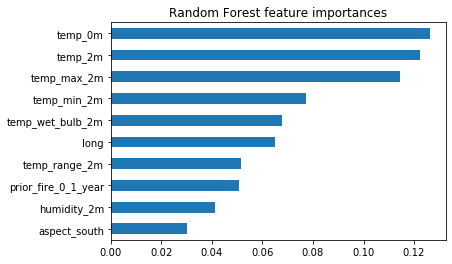

In [47]:
importances_rand_forest = rand_forest.best_estimator_.feature_importances_
importances_rand_forest = pd.Series(importances_rand_forest, index=df_fires_encoded.columns.values) \
  .sort_values().tail(15)

fig, ax = plt.subplots()
fig.set_figheight(6)
importances_rand_forest.plot.barh(ax=ax)
ax.set_title('Random Forest feature importances')

In [48]:
import xgboost as xgb

# params={
#   'objective': ['binary:logistic'],
#   'max_depth': [3, 6, 9],
#   'gamma':[0, 0.1, 0.4],
#   'learning_rate': [0.1, 0.2],
#   'n_estimators': [200],
#   'eval_metric': ['logloss']
# }
# For performance just use the best params from last run
params={
  'objective': ['binary:logistic'],
  'max_depth': [9],
  'gamma':[0.1],
  'learning_rate': [0.2],
  'n_estimators': [200],
  'eval_metric': ['logloss']
}

xgb_clf = xgb.XGBClassifier(seed=42, use_label_encoder=False)

xgb_clf = GridSearchCV(estimator=xgb_clf, scoring="recall", param_grid=params)

xgb_clf.fit(X_train, y_train)

print("Best Params:", xgb_clf.best_params_)

y_pred_xgb = xgb_clf.predict(X_test)

print('--------- XGBoost Classification Report ---------')
print(classification_report(y_test, y_pred_xgb))

Best Params: {'eval_metric': 'logloss', 'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 200, 'objective': 'binary:logistic'}
--------- XGBoost Classification Report ---------
              precision    recall  f1-score   support

       False       0.99      0.89      0.94     21901
        True       0.90      0.99      0.95     22108

    accuracy                           0.94     44009
   macro avg       0.95      0.94      0.94     44009
weighted avg       0.95      0.94      0.94     44009



Text(0.5, 1.0, 'XGBoost feature importances')

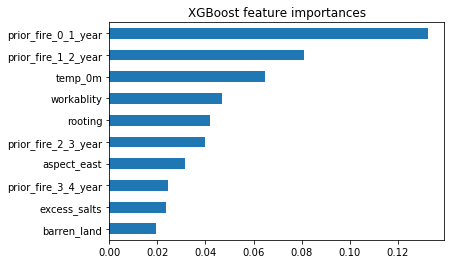

In [49]:
importances_xgb = xgb_clf.best_estimator_.feature_importances_
importances_xgb = pd.Series(importances_xgb, index=df_fires_encoded.columns.values).sort_values().tail(15)

fig, ax = plt.subplots()
fig.set_figheight(6)
importances_xgb.plot.barh(ax=ax)
ax.set_title('XGBoost feature importances')

In [50]:
import lightgbm as lgb

gbm = lgb.LGBMClassifier()

params = {
  'objective': ['binary'],
  'metric': ['binary_logloss'],
  'learning_rate': [0.01, 0.1, 0.2, 0.5, 0.8, 1.2],
  'num_leaves': [20, 40, 100, 500, 1000, 5000],
  'max_depth': np.arange(3, 12, 1),
  'min_data_in_leaf': np.arange(200, 2000, 200),
  'max_bin': [200, 300],
  'feature_fraction': np.arange(0.2, 0.9, 0.1),
  'bagging_fraction': np.arange(0.2, 0.9, 0.1),
  'bagging_freq': [1, 2, 5],
}

gbm = RandomizedSearchCV(estimator=gbm, param_distributions=params, scoring="recall", cv=3)
gbm.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] feature_fraction is set=0.7000000000000002, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000002
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=1800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1800
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] feature_fraction is set=0.7000000000000002, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7000000000000002
[LightGBM] [Warning] bagging_freq is s

RandomizedSearchCV(cv=3, estimator=LGBMClassifier(),
                   param_distributions={'bagging_fraction': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'bagging_freq': [1, 2, 5],
                                        'feature_fraction': array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
                                        'learning_rate': [0.01, 0.1, 0.2, 0.5,
                                                          0.8, 1.2],
                                        'max_bin': [200, 300],
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11]),
                                        'metric': ['binary_logloss'],
                                        'min_data_in_leaf': array([ 200,  400,  600,  800, 1000, 1200, 1400, 1600, 1800]),
                                        'num_leaves': [20, 40, 100, 500, 1000,
                                                       5000],
                             

In [51]:
print(f'Best params: {gbm.best_params_}')

y_pred_gbm = gbm.predict(X_test)

print('--------- LightGBM Classification Report ---------')
print(classification_report(y_test, y_pred_gbm))

Best params: {'objective': 'binary', 'num_leaves': 100, 'min_data_in_leaf': 400, 'metric': 'binary_logloss', 'max_depth': 7, 'max_bin': 300, 'learning_rate': 0.8, 'feature_fraction': 0.7000000000000002, 'bagging_freq': 2, 'bagging_fraction': 0.6000000000000001}
--------- LightGBM Classification Report ---------
              precision    recall  f1-score   support

       False       0.93      0.86      0.89     21901
        True       0.87      0.94      0.90     22108

    accuracy                           0.90     44009
   macro avg       0.90      0.90      0.90     44009
weighted avg       0.90      0.90      0.90     44009



Text(0.5, 1.0, 'LGBM feature importances')

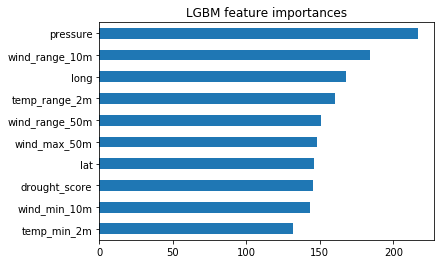

In [52]:
importances_gbm = gbm.best_estimator_.feature_importances_
importances_gbm = pd.Series(importances_gbm, index=df_fires_encoded.columns.values).sort_values().tail(15)

fig, ax = plt.subplots()
fig.set_figheight(6)
importances_gbm.plot.barh(ax=ax)
ax.set_title('LGBM feature importances')